# Poppy Universe – Layer 4: Master Neural Network Integration
 
Welcome to the **Poppy Universe Layer 4 – Master NN notebook**!  
This notebook integrates the **star, planet, and moon neural network predictions** into a single unified dataset for the recommendation engine. It ensures all user × type scores are combined for Layer 4 semantic ranking.
 
> Note: This notebook currently uses **simulated user interactions** to merge the NN predictions.  
> Once we have enough real interactions, the same pipeline will process actual user data for production recommendations.
 
---
 
## Goals
 
1. **Run Layer 4 NN notebooks for all categories**  
    - Execute Star, Planet, and Moon NN notebooks with backend data  
    - Fallback to existing predictions if data is insufficient  
 
2. **Load Layer 4 NN predictions from all notebooks**  
    - Stars, Planets, and Moons  
 
3. **Merge predicted matrices into a single user × type DataFrame**  
    - Users in rows, all category values as columns  
    - Fill missing values with 0 or appropriate defaults  
 
4. **Prepare final CSV for the engine**  
    - Clean schema, sorted columns  
    - Save to Output_Data for consumption by C# engine  
 
5. **Optional analysis & visualization**  
    - Heatmaps of top types per user  
    - Summary statistics across categories
 
---
 
## Folder & File References
 
 - **Files/Layer4_Star_Predictions.csv** → Star NN predictions  
 - **Files/Layer4_Planet_Predictions.csv** → Planet NN predictions  
 - **Files/Layer4_Moon_Predictions.csv** → Moon NN predictions  
 - **../../Output_Data/Layer4_Final_Predictions.csv** → Final merged predictions for engine  
 - **Plots/** → Optional heatmaps or visualizations
 
---
 
> Note: This notebook focuses **on merging all Layer 4 NN matrices**. Individual notebooks for Stars, Planets, and Moons remain separate to allow independent updates before final integration. 

## 0) Imports

In [43]:
import pandas as pd
import numpy as np
import os
import papermill as pm
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

## 1) Configuration and Backend Data Validation

In [44]:
# --- CONFIG / INPUT ---
# NN prediction CSV paths (fallback)
sim_star_path   = '../Files/Layer4_Star_Predictions.csv'
sim_planet_path = '../Files/Layer4_Planet_Predictions.csv'
sim_moon_path   = '../Files/Layer4_Moon_Predictions.csv'

# Backend-provided full interactions table (can be None)
backend_interactions_df = None  # backend sends 1 table with all interactions

# --- MINIMUM REQUIREMENTS ---
MIN_UNIQUE_USERS = 20
MIN_INTERACTIONS_PER_TYPE = 10  # per category type

# Create output directories if needed
os.makedirs('../Files', exist_ok=True)
os.makedirs('../../../Output_Data', exist_ok=True)
os.makedirs('../../Plots', exist_ok=True)

print("Configuration loaded")
print(f"Minimum users required: {MIN_UNIQUE_USERS}")
print(f"Minimum interactions per type: {MIN_INTERACTIONS_PER_TYPE}")


Configuration loaded
Minimum users required: 20
Minimum interactions per type: 10


## 2) Helper Function to Run NN Notebooks

In [45]:
def run_notebook_with_data(nb_path, interactions_df=None, sim_csv=None, param_name='backend_df'):
    """
    Runs a NN notebook via papermill, passing the interactions DataFrame as a parameter.
    Only runs if interactions_df meets minimum requirements.
    
    Args:
        nb_path: path to the notebook to execute
        interactions_df: backend DataFrame with interactions
        sim_csv: path to simulated CSV (for fallback reference)
        param_name: parameter name to inject into notebook
    """
    if interactions_df is not None:
        unique_users = interactions_df['User_ID'].nunique()
        interactions_per_type = interactions_df['Category_Type'].value_counts().min()
        
        if unique_users >= MIN_UNIQUE_USERS and interactions_per_type >= MIN_INTERACTIONS_PER_TYPE:
            print(f"\n✓ Running {nb_path} with backend data...")
            print(f"  Users: {unique_users}, Min interactions/type: {interactions_per_type}")
            
            try:
                pm.execute_notebook(
                    nb_path,
                    nb_path,  # overwrite notebook
                    parameters={param_name: interactions_df}
                )
                print(f"  ✓ {nb_path} completed successfully")
            except Exception as e:
                print(f"  ✗ Error running {nb_path}: {e}")
                print(f"  Will use existing predictions from {sim_csv}")
        else:
            print(f"\n✗ Skipping {nb_path}; backend data too sparse")
            print(f"  Users: {unique_users} (need {MIN_UNIQUE_USERS})")
            print(f"  Min interactions/type: {interactions_per_type} (need {MIN_INTERACTIONS_PER_TYPE})")
            print(f"  Will use existing predictions from {sim_csv}")
    else:
        print(f"\n✗ Skipping {nb_path}; backend data missing")
        print(f"  Will use existing predictions from {sim_csv}")

## 3) Run Component NN Notebooks

In [46]:
print("=" * 60)
print("RUNNING COMPONENT NN NOTEBOOKS")
print("=" * 60)

# Run Star NN notebook
run_notebook_with_data(
    'Star_NN_Model.ipynb', 
    interactions_df=backend_interactions_df, 
    sim_csv=sim_star_path
)

# Run Planet NN notebook
run_notebook_with_data(
    'Planet_NN_Model.ipynb',
    interactions_df=backend_interactions_df, 
    sim_csv=sim_planet_path
)

# Run Moon NN notebook
run_notebook_with_data(
    'Moon_NN_Model.ipynb',
    interactions_df=backend_interactions_df, 
    sim_csv=sim_moon_path
)

print("\n" + "=" * 60)
print("COMPONENT NOTEBOOKS COMPLETE")
print("=" * 60)

RUNNING COMPONENT NN NOTEBOOKS

✗ Skipping Star_NN_Model.ipynb; backend data missing
  Will use existing predictions from ../Files/Layer4_Star_Predictions.csv

✗ Skipping Planet_NN_Model.ipynb; backend data missing
  Will use existing predictions from ../Files/Layer4_Planet_Predictions.csv

✗ Skipping Moon_NN_Model.ipynb; backend data missing
  Will use existing predictions from ../Files/Layer4_Moon_Predictions.csv

COMPONENT NOTEBOOKS COMPLETE


## 4) Load Final NN Predictions

In [47]:
print("\nLoading NN predictions...")

# Check if files exist
for path, name in [(sim_star_path, 'Star'), (sim_planet_path, 'Planet'), (sim_moon_path, 'Moon')]:
    if not os.path.exists(path):
        print(f"✗ WARNING: {name} predictions not found at {path}")
    else:
        print(f"✓ Found {name} predictions at {path}")

# Load the final predictions
star_df   = pd.read_csv(sim_star_path)
planet_df = pd.read_csv(sim_planet_path)
moon_df   = pd.read_csv(sim_moon_path)

print("\n" + "=" * 60)
print("LOADED PREDICTIONS SUMMARY")
print("=" * 60)
print(f"Stars:   {star_df.shape} (users × star_types)")
print(f"Planets: {planet_df.shape} (users × planet_types)")
print(f"Moons:   {moon_df.shape} (users × moon_parents)")



Loading NN predictions...
✓ Found Star predictions at ../Files/Layer4_Star_Predictions.csv
✓ Found Planet predictions at ../Files/Layer4_Planet_Predictions.csv
✓ Found Moon predictions at ../Files/Layer4_Moon_Predictions.csv

LOADED PREDICTIONS SUMMARY
Stars:   (120, 8) (users × star_types)
Planets: (120, 5) (users × planet_types)
Moons:   (120, 11) (users × moon_parents)


## 5) Preview Individual Predictions

In [48]:
print("\n--- Star Predictions ---")
print(star_df.head())

print("\n--- Planet Predictions ---")
print(planet_df.head())

print("\n--- Moon Predictions ---")
print(moon_df.head())


--- Star Predictions ---
   User_ID         A         B         F         G         K         M  \
0        1  3.374687  3.487968  3.329048  3.275489  3.392254  3.299045   
1        2  3.230555  3.348081  3.256040  3.245267  3.367671  3.377338   
2        3  3.304385  3.362777  3.269798  3.283165  3.407863  3.429173   
3        4  3.171066  3.396097  3.287523  3.289830  3.438737  3.458244   
4        5  3.372962  3.582070  3.378999  3.355742  3.606762  3.389783   

          O  
0  3.303601  
1  3.075759  
2  3.193878  
3  3.366086  
4  3.298792  

--- Planet Predictions ---
   User_ID  Dwarf Planet  Gas Giant  Ice Giant  Terrestrial
0        1      3.453632   3.535491   3.563376     3.540907
1        2      3.582463   3.537353   3.708176     3.636297
2        3      3.408780   3.445135   3.480095     3.445913
3        4      3.383785   3.380357   3.409707     3.446287
4        5      3.312176   3.350153   3.429044     3.439409

--- Moon Predictions ---
   User_ID     Earth      Eris 

## 6) Validate Predictions

In [49]:
def validate_predictions(df, name):
    """Validate prediction DataFrame structure and values"""
    issues = []
    
    # Check for User_ID column
    if 'User_ID' not in df.columns:
        issues.append(f"Missing User_ID column")
    
    # Check for duplicate User_IDs
    if 'User_ID' in df.columns and df['User_ID'].duplicated().any():
        issues.append(f"Duplicate User_IDs found")
    
    # Check for NaN values
    if df.isnull().any().any():
        nan_cols = df.columns[df.isnull().any()].tolist()
        issues.append(f"NaN values in columns: {nan_cols}")
    
    # Check prediction ranges (should be between 1-5 for strength)
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if df[col].min() < 0 or df[col].max() > 10:  # allowing some buffer
            issues.append(f"Column {col} has values outside expected range [0-10]")
    
    if issues:
        print(f"\n⚠ Validation issues for {name}:")
        for issue in issues:
            print(f"  - {issue}")
    else:
        print(f"\n✓ {name} predictions validated successfully")
    
    return len(issues) == 0

# Validate all predictions
star_valid = validate_predictions(star_df, "Star")
planet_valid = validate_predictions(planet_df, "Planet")
moon_valid = validate_predictions(moon_df, "Moon")

if star_valid and planet_valid and moon_valid:
    print("\n✓ All predictions passed validation!")
else:
    print("\n⚠ Some predictions have validation issues - check above")



⚠ Validation issues for Star:
  - Column User_ID has values outside expected range [0-10]

⚠ Validation issues for Planet:
  - Column User_ID has values outside expected range [0-10]

⚠ Validation issues for Moon:
  - Column User_ID has values outside expected range [0-10]

⚠ Some predictions have validation issues - check above


## 7) Merge Star, Planet, and Moon Predictions

In [50]:
print("\n" + "=" * 60)
print("MERGING PREDICTIONS")
print("=" * 60)

# Verify all dataframes have the same users
star_users = set(star_df['User_ID'])
planet_users = set(planet_df['User_ID'])
moon_users = set(moon_df['User_ID'])

common_users = star_users & planet_users & moon_users
print(f"\nUsers in Star predictions: {len(star_users)}")
print(f"Users in Planet predictions: {len(planet_users)}")
print(f"Users in Moon predictions: {len(moon_users)}")
print(f"Common users across all: {len(common_users)}")

if len(common_users) < len(star_users):
    print("\n⚠ WARNING: Not all users appear in all prediction sets")
    print("  This may cause missing values in the merged dataset")

# Drop User_ID from planet and moon so it doesn't duplicate
planet_values = planet_df.drop('User_ID', axis=1)
moon_values = moon_df.drop('User_ID', axis=1)

# Concatenate horizontally
merged_df = pd.concat([star_df, planet_values, moon_values], axis=1)

# Optional: reorder columns so User_ID is first
cols = ['User_ID'] + [c for c in merged_df.columns if c != 'User_ID']
merged_df = merged_df[cols]

print(f"\n✓ Merged shape: {merged_df.shape}")
print(f"  Total features: {merged_df.shape[1] - 1} (excluding User_ID)")
print(f"  Total users: {merged_df.shape[0]}")

merged_df.head()


MERGING PREDICTIONS

Users in Star predictions: 120
Users in Planet predictions: 120
Users in Moon predictions: 120
Common users across all: 120

✓ Merged shape: (120, 22)
  Total features: 21 (excluding User_ID)
  Total users: 120


,User_ID,A,B,F,G,K,M,O,Dwarf Planet,Gas Giant,...,Earth,Eris,Haumea,Jupiter,Makemake,Mars,Neptune,Pluto,Saturn,Uranus
0,1,3.374687,3.487968,3.329048,3.275489,3.392254,3.299045,3.303601,3.453632,3.535491,...,3.317729,3.372776,3.301848,3.349454,3.409667,3.453566,3.368578,3.497113,3.345401,3.263951
1,2,3.230555,3.348081,3.256040,3.245267,3.367671,3.377338,3.075759,3.582463,3.537353,...,3.274866,3.352686,3.304060,3.310119,3.285074,3.371296,3.296369,3.354462,3.368783,3.227476
2,3,3.304385,3.362777,3.269798,3.283165,3.407863,3.429173,3.193878,3.408780,3.445135,...,3.376596,3.424115,3.331473,3.386874,3.432201,3.545526,3.417788,3.448155,3.449126,3.322976
3,4,3.171066,3.396097,3.287523,3.289830,3.438737,3.458244,3.366086,3.383785,3.380357,...,3.374441,3.431683,3.326288,3.393182,3.466983,3.485592,3.423131,3.472643,3.438282,3.402168
4,5,3.372962,3.582070,3.378999,3.355742,3.606762,3.389783,3.298792,3.312176,3.350153,...,3.339856,3.320063,3.302998,3.329571,3.376201,3.379391,3.368089,3.364556,3.426510,3.338830


## 8) Data Quality Check

In [51]:
print("\n" + "=" * 60)
print("DATA QUALITY REPORT")
print("=" * 60)

# Check for missing values
missing_count = merged_df.isnull().sum().sum()
print(f"\nMissing values: {missing_count}")

if missing_count > 0:
    print("\nColumns with missing values:")
    print(merged_df.isnull().sum()[merged_df.isnull().sum() > 0])
    
    # Fill missing values with 0 (no interaction/preference)
    print("\n→ Filling missing values with 0...")
    merged_df = merged_df.fillna(0)

# Summary statistics
numeric_cols = merged_df.select_dtypes(include=[np.number]).columns
print(f"\nPrediction statistics across {len(numeric_cols)} features:")
print(merged_df[numeric_cols].describe().T[['mean', 'std', 'min', 'max']].head(10))


DATA QUALITY REPORT

Missing values: 0

Prediction statistics across 22 features:
                   mean        std       min         max
User_ID       60.500000  34.785054  1.000000  120.000000
A              3.389451   0.096384  3.171066    3.622439
B              3.425351   0.105715  3.205396    3.817440
F              3.359810   0.099975  3.070312    3.645631
G              3.294492   0.077044  3.096073    3.540890
K              3.477260   0.102523  3.244554    3.806840
M              3.423297   0.093611  3.200704    3.679773
O              3.296897   0.091523  3.011071    3.574920
Dwarf Planet   3.365364   0.064288  3.228739    3.582463
Gas Giant      3.386909   0.062581  3.239373    3.540140


## 9) Visualize Prediction Distributions

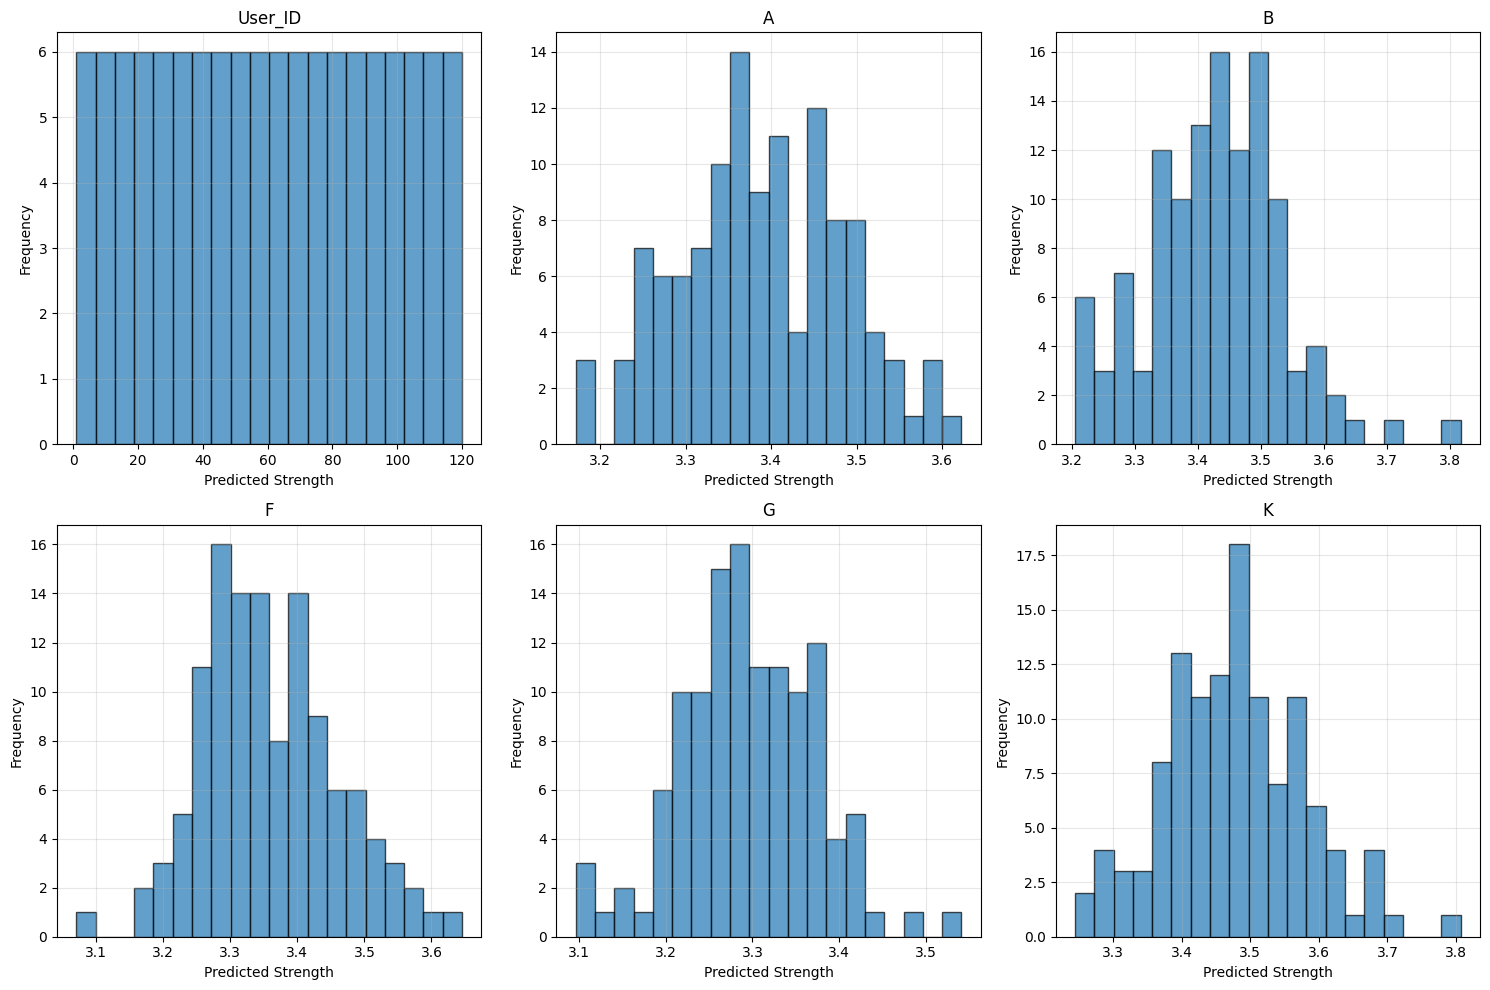


✓ Saved prediction distributions to ../../Plots/layer4_prediction_distributions.png


In [52]:
# Sample some columns for visualization
sample_cols = numeric_cols[:6] if len(numeric_cols) > 6 else numeric_cols

if len(sample_cols) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for idx, col in enumerate(sample_cols):
        if idx < len(axes):
            axes[idx].hist(merged_df[col], bins=20, alpha=0.7, edgecolor='black')
            axes[idx].set_title(f'{col}')
            axes[idx].set_xlabel('Predicted Strength')
            axes[idx].set_ylabel('Frequency')
            axes[idx].grid(True, alpha=0.3)
    
    # Hide unused subplots
    for idx in range(len(sample_cols), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.savefig('../../Plots/L4_prediction_distributions.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n✓ Saved prediction distributions to ../../Plots/layer4_prediction_distributions.png")


## 10) Create User Preference Heatmap

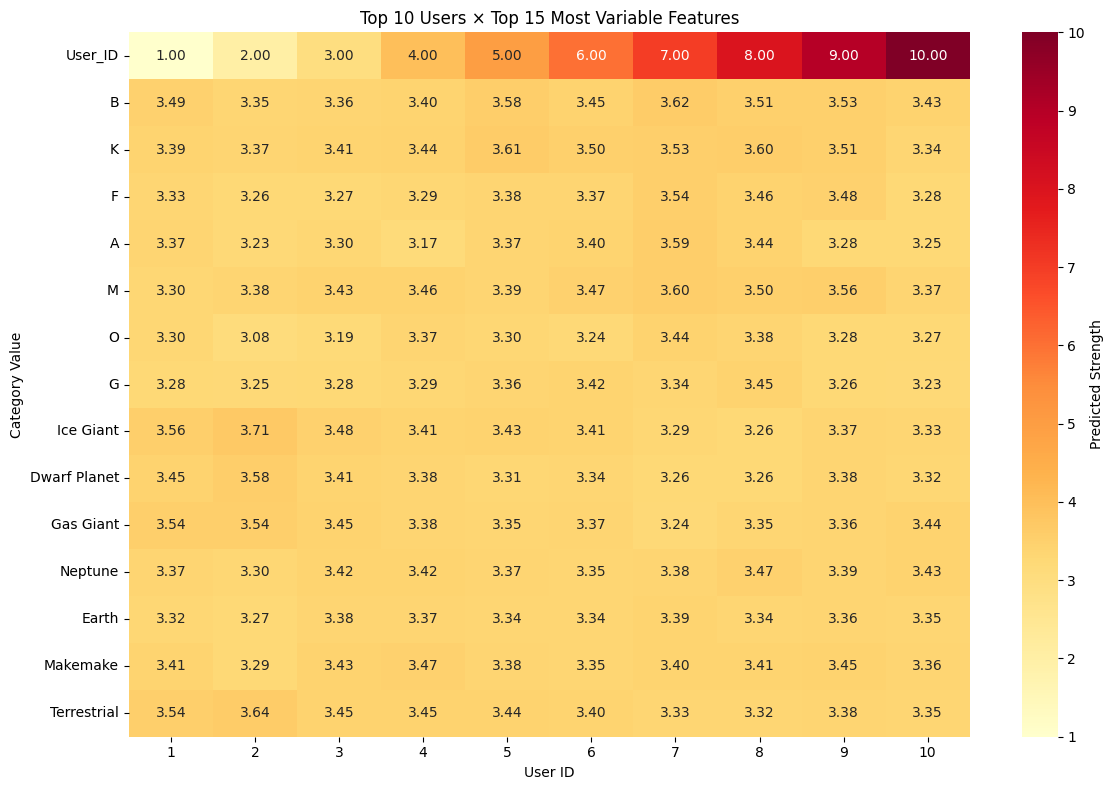


✓ Saved user preferences heatmap to ../../Plots/layer4_user_preferences_heatmap.png


In [53]:
# Create heatmap for top 10 users and top features
if merged_df.shape[0] >= 10:
    top_users = merged_df.head(10)
    
    # Get top 15 most variable features
    variances = merged_df[numeric_cols].var().sort_values(ascending=False)
    top_features = variances.head(15).index.tolist()
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        top_users[top_features].T, 
        cmap='YlOrRd', 
        annot=True, 
        fmt='.2f',
        cbar_kws={'label': 'Predicted Strength'},
        xticklabels=top_users['User_ID'].astype(str),
        yticklabels=top_features
    )
    plt.title('Top 10 Users × Top 15 Most Variable Features')
    plt.xlabel('User ID')
    plt.ylabel('Category Value')
    plt.tight_layout()
    plt.savefig('../../Plots/L4_user_preferences_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n✓ Saved user preferences heatmap to ../../Plots/layer4_user_preferences_heatmap.png")


## 11) Analyze Top Preferences Per User

In [54]:
# For each user, find their top 5 predicted categories
print("\n" + "=" * 60)
print("TOP 5 PREFERENCES PER USER (Sample)")
print("=" * 60)

sample_users = merged_df['User_ID'].head(5)

for user_id in sample_users:
    user_row = merged_df[merged_df['User_ID'] == user_id].iloc[0]
    user_predictions = user_row[numeric_cols].sort_values(ascending=False)
    
    print(f"\nUser {user_id}:")
    for i, (category, score) in enumerate(user_predictions.head(5).items(), 1):
        print(f"  {i}. {category}: {score:.3f}")


TOP 5 PREFERENCES PER USER (Sample)

User 1:
  1. Ice Giant: 3.563
  2. Terrestrial: 3.541
  3. Gas Giant: 3.535
  4. Pluto: 3.497
  5. B: 3.488

User 2:
  1. Ice Giant: 3.708
  2. Terrestrial: 3.636
  3. Dwarf Planet: 3.582
  4. Gas Giant: 3.537
  5. M: 3.377

User 3:
  1. Mars: 3.546
  2. Ice Giant: 3.480
  3. Saturn: 3.449
  4. Pluto: 3.448
  5. Terrestrial: 3.446

User 4:
  1. User_ID: 4.000
  2. Mars: 3.486
  3. Pluto: 3.473
  4. Makemake: 3.467
  5. M: 3.458

User 5:
  1. User_ID: 5.000
  2. K: 3.607
  3. B: 3.582
  4. Terrestrial: 3.439
  5. Ice Giant: 3.429


## 12) Save Final Merged Matrix for Engine

In [55]:
print("\n" + "=" * 60)
print("SAVING FINAL PREDICTIONS")
print("=" * 60)

output_path = '../../../Output_Data/Layer4_Final_Predictions.csv'

# Save the merged predictions
merged_df.to_csv(output_path, index=False)

print(f"\n✓ Saved Layer4_Final_Predictions.csv")
print(f"  Location: {output_path}")
print(f"  Shape: {merged_df.shape}")
print(f"  Size: {os.path.getsize(output_path) / 1024:.2f} KB")

# Create a metadata file
metadata = {
    'timestamp': datetime.now().isoformat(),
    'num_users': len(merged_df),
    'num_features': len(numeric_cols),
    'star_features': len(star_df.columns) - 1,
    'planet_features': len(planet_df.columns) - 1,
    'moon_features': len(moon_df.columns) - 1,
    'prediction_range': [float(merged_df[numeric_cols].min().min()), 
                        float(merged_df[numeric_cols].max().max())],
    'mean_prediction': float(merged_df[numeric_cols].mean().mean()),
    'std_prediction': float(merged_df[numeric_cols].std().mean())
}

metadata_df = pd.DataFrame([metadata])
metadata_df.to_csv('../../../Output_Data/Layer4_Metadata.csv', index=False)

print(f"\n✓ Saved Layer4_Metadata.csv")
print("\nMetadata:")
for key, value in metadata.items():
    print(f"  {key}: {value}")



SAVING FINAL PREDICTIONS

✓ Saved Layer4_Final_Predictions.csv
  Location: ../../../Output_Data/Layer4_Final_Predictions.csv
  Shape: (120, 22)
  Size: 45.75 KB

✓ Saved Layer4_Metadata.csv

Metadata:
  timestamp: 2025-12-18T19:29:14.608364
  num_users: 120
  num_features: 22
  star_features: 7
  planet_features: 4
  moon_features: 10
  prediction_range: [1.0, 120.0]
  mean_prediction: 5.970142077218597
  std_prediction: 1.6469346294758962


## 13) Final Summary

In [56]:
print("\n" + "=" * 60)
print("LAYER 4 MASTER NN INTEGRATION COMPLETE")
print("=" * 60)

print("\n✓ Successfully integrated all NN predictions:")
print(f"  → {len(star_df.columns) - 1} star type features")
print(f"  → {len(planet_df.columns) - 1} planet type features")
print(f"  → {len(moon_df.columns) - 1} moon parent features")
print(f"  → Total: {len(numeric_cols)} features for {len(merged_df)} users")

print("\n✓ Output files created:")
print(f"  → {output_path}")
print(f"  → ../../../Output_Data/Layer4_Metadata.csv")

print("\n✓ Visualizations created:")
print("  → ../Plots/L4_prediction_distributions.png")
print("  → ../Plots/L4_user_preferences_heatmap.png")

print("\n🎉 Layer 4 predictions ready for recommendation engine!")


LAYER 4 MASTER NN INTEGRATION COMPLETE

✓ Successfully integrated all NN predictions:
  → 7 star type features
  → 4 planet type features
  → 10 moon parent features
  → Total: 22 features for 120 users

✓ Output files created:
  → ../../../Output_Data/Layer4_Final_Predictions.csv
  → ../../../Output_Data/Layer4_Metadata.csv

✓ Visualizations created:
  → ../Plots/L4_prediction_distributions.png
  → ../Plots/L4_user_preferences_heatmap.png

🎉 Layer 4 predictions ready for recommendation engine!
